<a href="https://colab.research.google.com/github/mannyadeniji/C-Practice/blob/main/RL_SHAP_toy_example_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Packages

In [ ]:
!pip install setuptools==65.5.0 pip==21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.
pip-tools 6.13.0 requires pip>=22.2, but you have pip 21.0 which is incompatible.


In [ ]:
!pip install stable-baselines3

     |████████████████████████████████| 178 kB 2.2 MB/s 
     |████████████████████████████████| 925 kB 8.9 MB/s 


In [ ]:
!pip install shap

     |████████████████████████████████| 547 kB 2.2 MB/s 


In [ ]:
!pip install  shimmy>=0.2.1

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install highway-env

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,230 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,087 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [25.6 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/u

#Import Packages

In [ ]:
#Import necessary libraries
import gymnasium
import highway_env
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import sys
from base64 import b64encode
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from pathlib import Path
from stable_baselines3 import A2C, PPO, SAC, HerReplayBuffer
from stable_baselines3.common.env_util import make_vec_env
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from gymnasium.wrappers import RecordVideo
%matplotlib inline
highway_env.register_highway_envs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
distutils Version classes are deprecated. Use packaging.version instead.
WARN: Overriding environment exit-v0 already in registry.
WARN: Overriding environment highway-v0 already in registry.
WARN: Overriding environment highway-fast-v0 already in registry.
WARN: Overriding environment intersection-v0 already in registry.
WARN: Overriding environment intersection-v1 already in registry.
WARN: Overriding environment intersection-multi-agent-v0 already in registry.
WARN: Overriding environment intersection-multi-agent-v1 already in registry.
WARN: Overriding environment lane-keeping-v0 already in registry.
WARN: Overriding environment merge-v0 already in registry.
WARN: Overriding environment parking-v0 already in registry.
WARN: Overriding environment parking-ActionRepeat-v0 already in registry.
WARN: Overriding environment parking-parked-v0 already in registry.
WARN:

#Reusable Functions

In [ ]:
#Evaluates the Agent in the Given Environment for 100 episodes
def evaluate_agent(model, num_episodes=100):
  total_reward = 0

  for _ in range(num_episodes):
      vec_env = model.get_env()
      obs = vec_env.reset()
      done = False
      episode_reward = 0

      while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = vec_env.step(action)
        episode_reward += reward

      total_reward += episode_reward

  avg_reward = total_reward / num_episodes

  return avg_reward

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
#Collects Data for 1000 timesteps and also creates a video rendering of the data collected
def render_and_collect_data(model, name):
  dataset_states = []
  dataset_actions = []

  vec_env = model.get_env()
  obs = vec_env.reset()
  video_name = name + ".mp4"
  video = VideoRecorder(vec_env, video_name)

  for i in range(1000):
    vec_env.render()
    video.capture_frame()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)

    if done:
      obs = vec_env.reset()

    dataset_states.append(obs)
    dataset_actions.append(action)

  video.close()
  vec_env.close()
  return np.array(dataset_states), np.array(dataset_actions)

In [ ]:
def render_mp4(videopath: str) -> str:
  """
    Gets a string containing a b4-encoded version of the MP4 video
    at the specified path
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
        f'base64,{base64_encoded_mp4} type="video/mp4"></video>'

In [ ]:
def explanations(model, observations, f_names):
  shap.initjs()
  def kernel(X):
    return model.predict(X, deterministic=True)[0]

  explainer = shap.KernelExplainer(kernel, observations)
  shap_values = explainer.shap_values(observations)
  explanation = shap.Explanation(shap_values, explainer.expected_value, observations, feature_names=f_names)

  shap.summary_plot(explanation)
  shap.plots.waterfall(explanation[0])
  shap.plots.scatter(explanation)
  shap.initjs()
  shap.force_plot(explanation[0])

#Cartpole Environment

##PPO Model

In [ ]:
c_env = gymnasium.make("CartPole-v1", render_mode="rgb_array")
ppo_model = PPO("MlpPolicy", c_env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
ppo_model.learn(total_timesteps=10_000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 20.7     |
| time/              |          |
|    fps             | 316      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.4        |
|    ep_rew_mean          | 25.4        |
| time/                   |             |
|    fps                  | 391         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008685917 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.000189    |
|    learning_rate        | 0.

In [ ]:
ppo_avg_reward = evaluate_agent(ppo_model)
print(f"Average PPO reward: {ppo_avg_reward}")

Average PPO reward: [146.3]


In [ ]:
ppo_states, ppo_actions = render_and_collect_data(ppo_model, "ppo")

WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.


In [ ]:
html_ppo = render_mp4("ppo.mp4")
HTML(html_ppo)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
ppo_reshaped = np.reshape(ppo_states, (1000, 4))

##PPO Explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

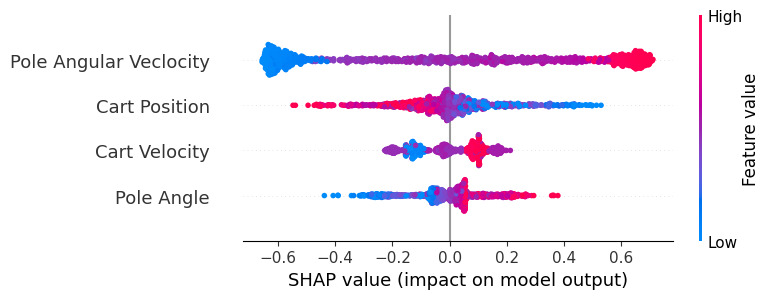

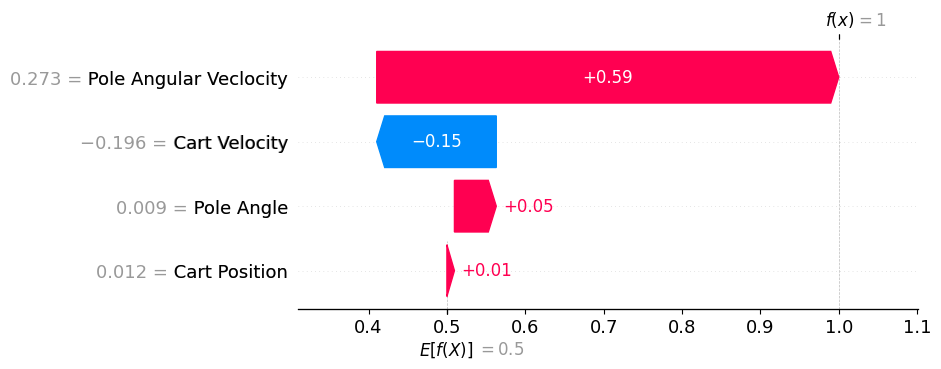

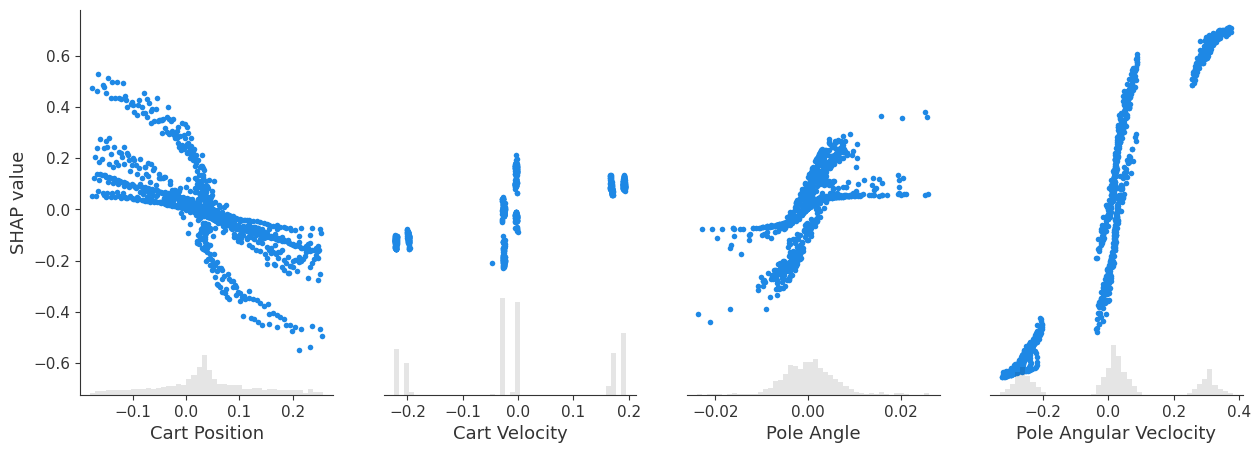

In [ ]:
feature_names = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Veclocity']
explanations(ppo_model, ppo_reshaped, feature_names)

##A2C Model

In [ ]:
a2c_model = A2C("MlpPolicy", c_env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
a2c_model.learn(total_timesteps=50_000)

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 20.8     |
|    ep_rew_mean        | 20.8     |
| time/                 |          |
|    fps                | 453      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.678   |
|    explained_variance | 0.226    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.35     |
|    value_loss         | 5.45     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.9     |
|    ep_rew_mean        | 21.9     |
| time/                 |          |
|    fps                | 458      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|

In [ ]:
a2c_avg_reward = evaluate_agent(a2c_model)
print(f"Average A2C reward: {a2c_avg_reward}")

Average A2C reward: [455.73]


In [ ]:
a2c_states, a2c_actions = render_and_collect_data(a2c_model, "a2c")

WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.


In [ ]:
html_a2C = render_mp4("a2c.mp4")
HTML(html_a2C)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
a2c_reshaped = np.reshape(a2c_states, (1000, 4))

##A2C Explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


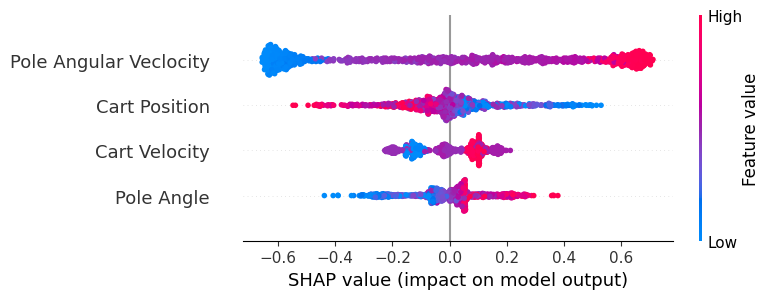

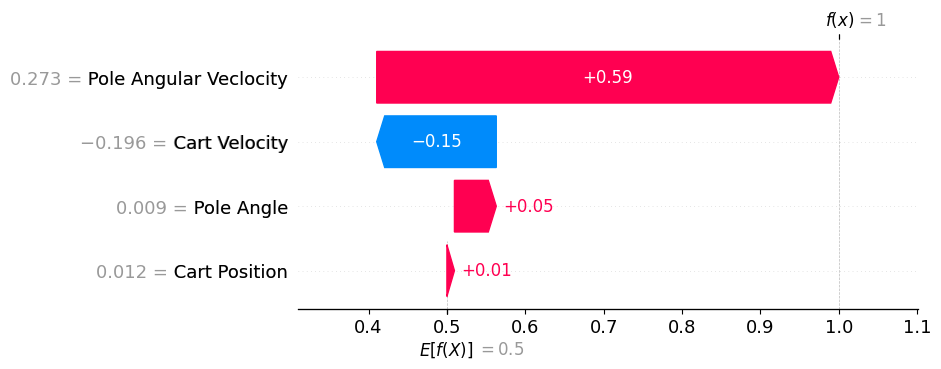

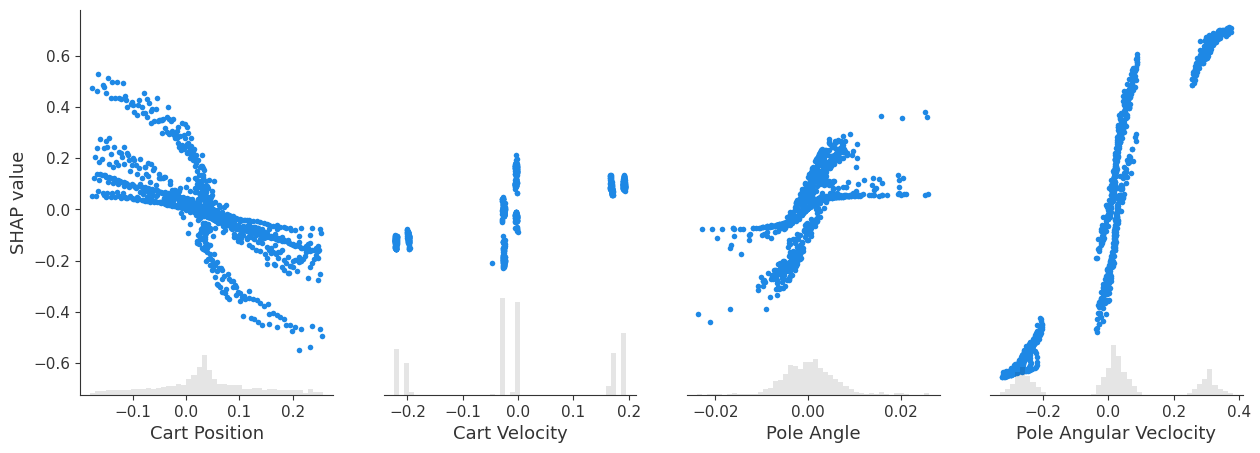

In [ ]:
a2c_feature_names = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Veclocity']
explanations(ppo_model, ppo_reshaped, feature_names)

#Parking Environment

##SAC Model

In [ ]:
s_env = gymnasium.make('parking-v0', render_mode='rgb_array')

In [ ]:
LEARNING_STEPS = 5e4
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
sac_model_parking = SAC("MultiInputPolicy", s_env,
                        replay_buffer_class=HerReplayBuffer,
                        replay_buffer_kwargs=her_kwargs,
                        verbose=1,
                        buffer_size=int(1e6),
                        learning_rate=1e-3,
                        gamma=0.95,
                        batch_size=1024,
                        tau=0.05,
                        device="cuda",
                        policy_kwargs=dict(net_arch=[512, 512, 512]))


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
sac_model_parking.learn(total_timesteps=50_000)

Streaming output truncated to the last 5000 lines.
|    success_rate    | 0.9      |
| time/              |          |
|    episodes        | 400      |
|    fps             | 32       |
|    time_elapsed    | 705      |
|    total_timesteps | 22814    |
| train/             |          |
|    actor_loss      | 1.75     |
|    critic_loss     | 0.0068   |
|    ent_coef        | 0.00388  |
|    ent_coef_loss   | 0.148    |
|    learning_rate   | 0.001    |
|    n_updates       | 22713    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.6     |
|    ep_rew_mean     | -10.7    |
|    success_rate    | 0.89     |
| time/              |          |
|    episodes        | 404      |
|    fps             | 32       |
|    time_elapsed    | 707      |
|    total_timesteps | 22898    |
| train/             |          |
|    actor_loss      | 1.71     |
|    critic_loss     | 0.00496  |
|    ent_coef        | 0.00396 

In [ ]:
sac_avg_reward = evaluate_agent(sac_model_parking)
print(f"Average reward: {sac_avg_reward}")

Average reward: [-6.862793]


In [ ]:
sac_states_parking, sac_actions_parking = render_and_collect_data(sac_model_parking, "sac_parking")

WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.


In [ ]:
sac_parking = render_mp4("sac_parking.mp4")
HTML(sac_parking)

In [ ]:
sac_states_parking = np.reshape(sac_states_parking, (1000, 1))

In [ ]:
#sacParkingKernel = lambda X: sac_model_parking.predict(X, deterministic=True)
def sacParking(X):
  action, _ = sac_model_parking.predict(X, deterministic=True)
  return action

In [ ]:
sac_parking_explainer = shap.KernelExplainer(sacParking, sac_states_parking)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


IndexError: ignored

In [ ]:
sac_parking_shap_values = sac_parking_explainer.shap_values(sac_states_parking)

shap_values() is deprecated; use __call__().


IndexError: ignored

In [ ]:
parking_feature_names = ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']

In [ ]:
sac_parking_explanation = shap.Explanation(sac_parking_shap_values, sac_parking_explainer.expected_value, sac_states_parking, feature_names=parking_feature_names)

In [ ]:
shap.summary_plot(sac_parking_explanation)

In [ ]:
shap.initjs()
shap.force_plot(sac_parking_explanation[0])

In [ ]:
shap.plots.waterfall(sac_parking_explanation[0])

In [ ]:
shap.plots.scatter(sac_parking_explanation)